In [1]:
import alborexdata
import netCDF4
import glob
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
import cmocean
from importlib import reload

## Configuration

In [2]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

Domain

In [3]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]

In [4]:
datafile = config["datafiles"]["adcp"]
os.path.exists(datafile)
figdir = "../figures/ADCP/"

Front

In [5]:
frontcoords = "../data/front_coordinates.dat"
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

## Figure

In [6]:
m = Basemap(projection='merc', llcrnrlon=coordinates2[0], llcrnrlat=coordinates2[2],
            urcrnrlon=coordinates2[1], urcrnrlat=coordinates2[3],
            lat_ts=0.5 * (coordinates2[2] + coordinates2[3]), resolution='h')

In [7]:
adcp = alborexdata.Adcp()
adcp.get_from_netcdf(datafile)
adcp.apply_qc(qf=1)
adcp.get_norm()

/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py:610: RuntimeWarning: invalid value encountered in sqrt
  self.velnorm = np.sqrt(self.u * self.u + self.v * self.v)


## Figures
### Quality flag for the whole section

In [8]:
cmap_error = plt.cm.get_cmap('hot_r', 9)
xx, yy = np.meshgrid(adcp.time, adcp.depth)
tt = netCDF4.num2date(xx, adcp.timeunits)
dt = adcp.time[1:] - adcp.time[:-1]
gaps = np.where(dt > 1000)[0]

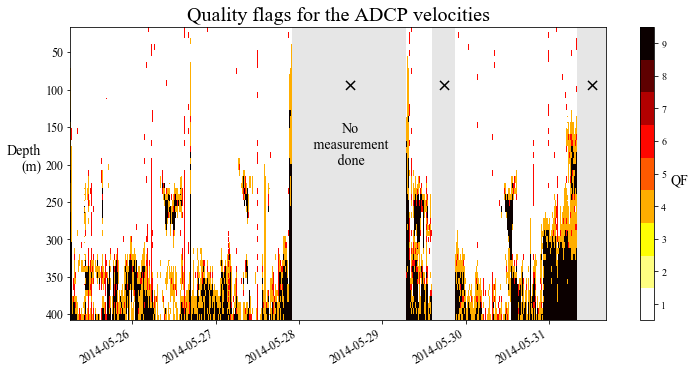

In [35]:
figname = "fig09b"
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
ax.set_facecolor(".9")

# Plot separate pcolor to avoid color interpolation during periods 
# without data

imin = 0
for nig, ig in enumerate(gaps):
    imax = ig
    plt.pcolormesh(adcp.dates[imin:imax], adcp.depth, adcp.qcu[imin:imax,:].T, 
                   cmap=cmap_error, vmin=0.5, vmax = 9.5)
    datemean = netCDF4.num2date(0.5 * (adcp.time[ig] + adcp.time[ig+1]), adcp.timeunits)
    if nig < 2:
        plt.text(datemean, 100, r"$\times$", fontsize=18, ha="center")
    elif nig == 2:
        datemean = netCDF4.num2date(0.5 * (adcp.time[ig] + adcp.time[-1]), adcp.timeunits)
        plt.text(datemean, 100, r"$\times$", fontsize=18, ha="center")
    imin = imax+1
    
# Add text in no data period
datemean = netCDF4.num2date(0.5 * (adcp.time[gaps[0]] + adcp.time[gaps[0]+1]), adcp.timeunits)
plt.text(datemean, 200, "No\n measurement\n done", 
         fontsize=14, ha="center")


plt.gca().invert_yaxis()
plt.ylabel("Depth\n(m)", rotation=0, ha="right", fontsize=14)
cb = plt.colorbar()
cb.set_ticks(range(0, 10))
cb.set_label("QF", rotation=0, ha="left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Quality flags for the ADCP velocities", fontsize=20)
plt.xlim(adcp.dates[0], adcp.dates[-1])
fig.autofmt_xdate()
plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### subtitle

25
26
27
28
29
30


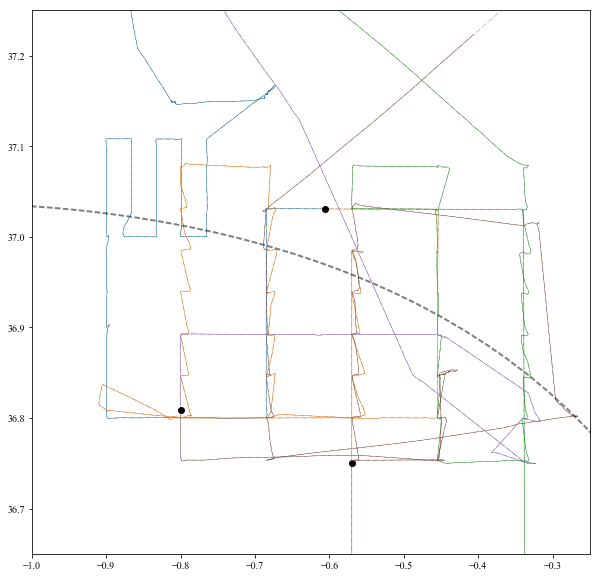

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(adcp.lon, adcp.lat, "k--", lw=.2)
for d in range(25, 31):
    print(d)
    gooddates = np.where((adcp.dates >= datetime.datetime(2014, 5, d)) & 
                         (adcp.dates <= datetime.datetime(2014, 5, d+1)))[0]
    plt.plot(adcp.lon[gooddates], adcp.lat[gooddates], lw=.5)
    if len(gooddates) > 0:
        plt.plot(adcp.lon[gooddates[0]], adcp.lat[gooddates[0]], "ko")
        
plt.xlim(coordinates2[0], coordinates2[1])
plt.ylim(coordinates2[2], coordinates2[3])
plt.plot(f.lon, f.lat, "k--", lw=2, alpha=.5)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(adcp.lon, adcp.lat, "k--", lw=.2)
plt.plot(adcp.lon[gooddates], adcp.lat[gooddates], "r", lw=.5)
plt.show()
plt.close()

### Scatter plot all depths

In [ ]:
llon, llat = m(adcp.lon, adcp.lat)
for idepth, depth in enumerate(adcp.depth[0:1]):
    figname = "ADCP_{}".format(str(idepth).zfill(4))
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    m.plot(adcp.lon, adcp.lat, "k--", lw=.2, latlon=True)
    qv = plt.quiver(llon, llat, 
               adcp.u[:,idepth] / adcp.velnorm[:, idepth], 
               adcp.v[:,idepth] / adcp.velnorm[:, idepth], 
               adcp.velnorm[:,idepth], headwidth=0, scale=25, cmap=cmocean.cm.speed)
    cb = plt.colorbar(qv, shrink=0.8, extend="max")
    cb.set_label("$\|v\|$\n(m/s)", rotation=0, ha="left", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.clim(0, 1.)
    m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)
    alborexdata.add_map_grid(m, coordinates2, dlon=0.25, dlat=0.25,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6")
    plt.title("Depth: {} m".format(depth), fontsize=20)
    # plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Full mission

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
plt.pcolormesh(adcp.dates, adcp.depth, adcp.qcu.T, cmap=cmap_error, vmin=-.5, vmax = 9.5)
plt.gca().invert_yaxis()
plt.ylabel("Depth (m)", rotation=0, ha="right", fontsize=14)
cb = plt.colorbar()
cb.set_ticks(range(0, 10))
cb.set_label("QF", rotation=0, ha="left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Quality flags for the ADCP velocities", fontsize=20)
plt.show()
plt.close()

### Plot selected sections

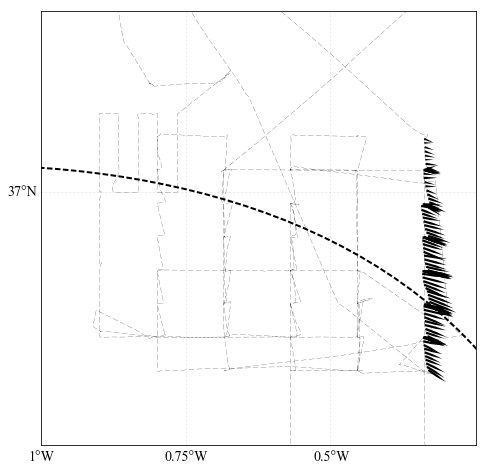

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
#NN1, NN2 = 1462, 1600
#NN1, NN2 = 1640, 1780
llon, llat = m(adcp.lon[NN1:NN2], adcp.lat[NN1:NN2])
m.plot(adcp.lon, adcp.lat, "k--", lw=.2, latlon=True)
#plt.plot(dataadcp["AnLLonDeg"], dataadcp["AnLLatDeg"], 'r--', lw=.2)

plt.quiver(llon, llat, adcp.u[NN1:NN2,0], adcp.v[NN1:NN2,0], headwidth=1)
m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)
alborexdata.add_map_grid(m, coordinates2, dlon=0.25, dlat=0.25,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6")
plt.show()
plt.close()

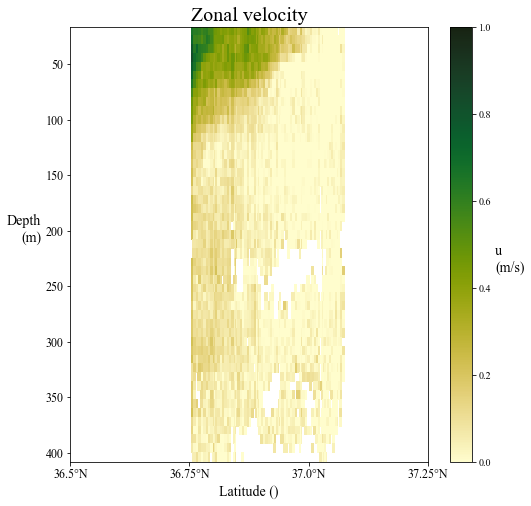

In [53]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
NN1, NN2 = 1462, 1600
plt.pcolormesh(adcp.lat[NN1:NN2], adcp.depth, adcp.u[NN1:NN2,:].T, 
               cmap=cmocean.cm.speed, vmin=0., vmax=1.)
plt.gca().invert_yaxis()
plt.xlabel("Latitude ()", fontsize=14)
plt.ylabel("Depth\n(m)", rotation=0, ha="right", fontsize=14)
cb = plt.colorbar()
cb.set_label("u\n(m/s)", rotation=0, ha="left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Zonal velocity", fontsize=20)
xticks = np.arange(36.5, 37.5, 0.25)
xticklabels = ["{}°N".format(xt) for xt in xticks]
plt.xticks(xticks, xticklabels)

ax.get_xticklabels()
#plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

array([ 36.5 ,  36.75,  37.  ,  37.25])